# **Курсовая работа**

Нужно написать приложение, которое будет получать на вход изображение.
В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.

**Мы используем представленную базу данных распознавания жестов рук, которая состоит из набора изображений в инфракрасном диапазоне, полученных датчиком Leap Motion. База данных состоит из 10 различных жестов рук.**

## **В качестве основы мы будем использовать предварительно обученную модель ResNet50.**

ResNet50 - это архитектура глубокой конволюционной нейронной сети для задач классификации изображений. Она была представлена в 2015 году и представляет собой 50-слойную сеть с остаточными связями, отсюда и название "ResNet50". Остаточные связи в сети позволяют обучать очень глубокие нейронные сети, и ResNet50 достигла наилучших результатов на нескольких эталонных наборах данных для классификации изображений.

ResNet50 широко используется в различных задачах и приложениях компьютерного зрения, включая распознавание объектов, классификацию изображений и семантическую сегментацию, благодаря своей способности к обучению надежным признакам и работе с большими объемами данных. Кроме того, она эффективна с вычислительной точки зрения и может быть обучена с использованием небольшого количества вычислительных ресурсов, что делает ее популярным выбором для широкого круга реальных приложений.

**Импорт необходимых библиотек**

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset, Subset
import torchvision.transforms as tt
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
from time import time
from torch.autograd import Variable
import cv2
from PIL import Image

from pathlib import Path

In [2]:
DATA_ROOT = Path('./Dataset/leapGestRecog/')

**Сохраним имена классов, загрузив одну из папок:**

In [3]:
tmp_ds = ImageFolder(DATA_ROOT / '00')
CLASSES_NAME =[]
for i in tmp_ds.classes:
    CLASSES_NAME.append(i[3:])
CLASSES_NAME

['palm',
 'l',
 'fist',
 'fist_moved',
 'thumb',
 'index',
 'ok',
 'palm_moved',
 'c',
 'down']

**Зададим преобразования для обучающих и тестововых изображений. Для Grayscale установим число выходных слоев равным 3, поскольку resnet не принимает одноканальные изображения**

In [4]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3), # Фотографии черно-белые
                         tt.Resize([128, 128]),
                         # Настройки для расширения набора данных
                         tt.RandomHorizontalFlip(),           # Произвольные повороты на 90 градусов
                         tt.RandomRotation(30),               # Произвольные повороты на 30 градусов
                         tt.ToTensor(),                       # Приведение к тензору
                         ])                      

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128, 128]),
                        tt.ToTensor(),
                        ])
     

**Создадим обучающие и тестовые наборы данных с одними и теми же изображениями, но с разной предварительной обработкой:**

In [5]:
train_ds_list = []
test_ds_list = []
for dir in os.listdir(DATA_ROOT):
    train_ds = ImageFolder(os.path.join(DATA_ROOT, dir), train_tfms)
    test_ds = ImageFolder(os.path.join(DATA_ROOT, dir), test_tfms)
    train_ds_list.append(train_ds)
    test_ds_list.append(test_ds)

train_ds = ConcatDataset(train_ds_list)
test_ds = ConcatDataset(test_ds_list)

**Общее количество изображений:**

In [6]:
LEN_DS = len(train_ds)
LEN_DS

20000

**Функция преобразования номера класса в его название:**

In [7]:
def digit_to_classname(digit):
    return CLASSES_NAME[digit]

**Рассмотрим распределение классов в наборе данных:**

**В этом коде сначала подсчитывается количество образцов каждого класса в обучающем наборе с помощью класса Counter из модуля collections. Затем объект Counter используется для построения гистограммы, отображающей распределение классов в обучающем наборе.**

Counter({0: 2000, 1: 2000, 2: 2000, 3: 2000, 4: 2000, 5: 2000, 6: 2000, 7: 2000, 8: 2000, 9: 2000})


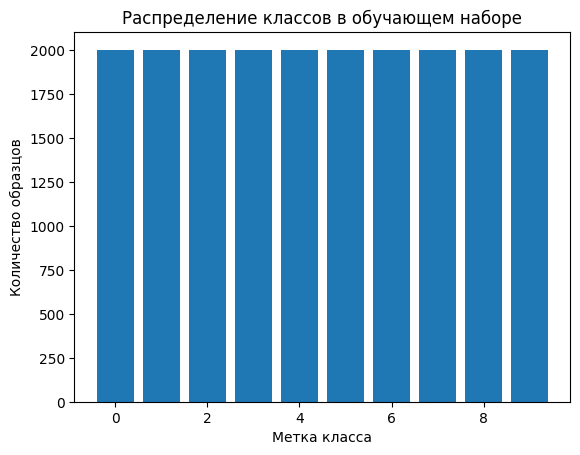

In [8]:
from collections import Counter

train_counts = Counter([label for _, label in train_ds])
print(train_counts)

plt.bar(train_counts.keys(), train_counts.values())
plt.xlabel('Метка класса')
plt.ylabel('Количество образцов')
plt.title('Распределение классов в обучающем наборе')
plt.show()

**Распределение по классам равномерное.**

### Разбиваем набор на обучающую и тестовую часть  

Так как у нас два одинаковых набора, но с разной предобработкой, возьмем из них не повторяющиеся изображения

In [9]:
torch.manual_seed(1)
# Задаем тестовую часть, как 1/5 от общего
val_split = 0.2
# Высчитываем размер тестовой части
split = int(LEN_DS * val_split)

indices = torch.randperm(LEN_DS)

train_ds = Subset(train_ds, indices[split:])
test_ds = Subset(test_ds, indices[:split])

len(train_ds), len(test_ds)

(16000, 4000)

**Проверим размерность случайного тензора в наборе данных:**

In [10]:
train_ds[15000][0].size()

torch.Size([3, 128, 128])

### **Создадим dataloaders:**

In [11]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

**Выведем произвольное изображение:**

torch.Size([3, 128, 128])
tensor(2) fist


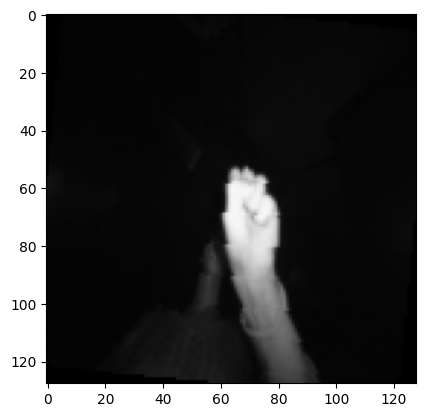

In [12]:
for img, l in train_dl:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0))
    break

**Функция визуализации батча:**

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([3, 128, 128])


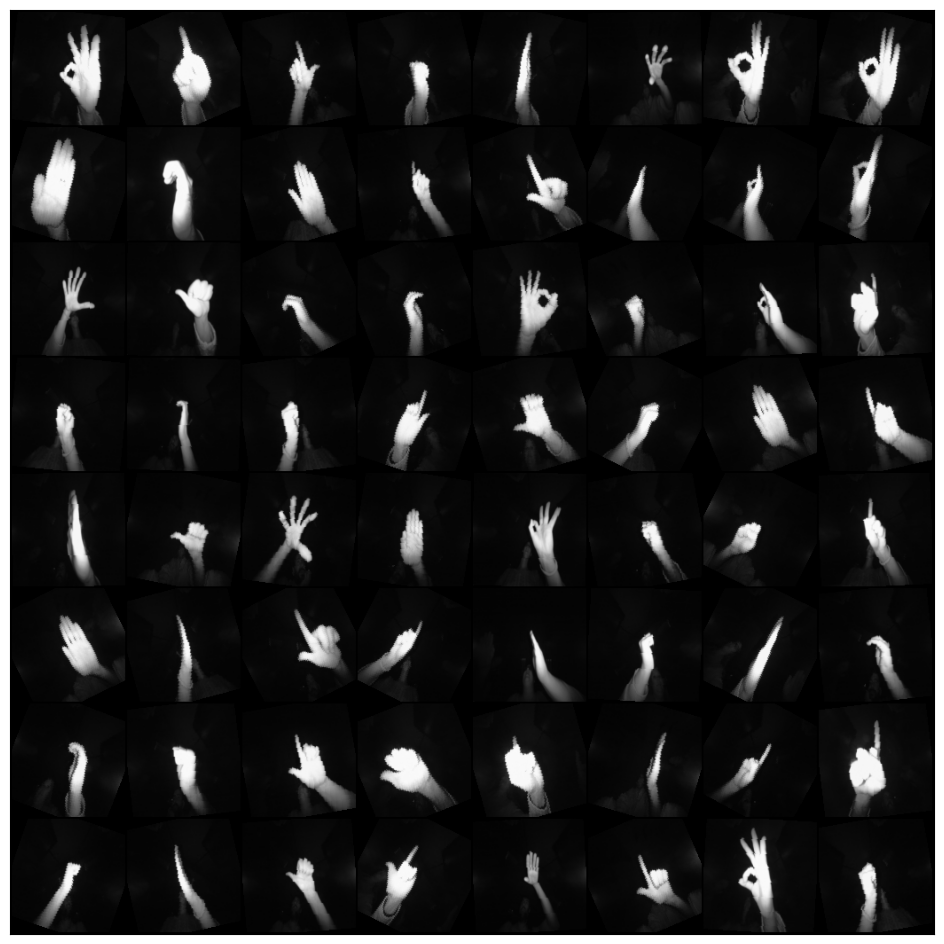

In [14]:
show_batch(train_dl)

**Определим устройство для работы нейронных сетей:**

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

**Возьмем для классификации предварительно обученную сеть resnet50:**

In [16]:
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)


In [17]:
summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

**Запретим весам учиться**

In [18]:
for param in resnet.parameters():
    param.requires_grad = False

In [19]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Перезапишем последний классификационный слой и убедимся, что остальные слои не будут обучаться:**

In [20]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(CLASSES_NAME))
resnet.fc = fc

summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

**Создадим список обучаемых параметров и передадим его оптимизатору. Также инициализируем функцию потерь:**

In [21]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

        
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)


Инициализируем функцию для обучения сети:

In [22]:
def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in range(num_epoch):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

           
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Логирование
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'./Model/Checkpoints/checkpoint_resnet50_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

**Обучим сеть на 15 эпохах:**

In [23]:
print_every = 50
num_epoch = 15

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=num_epoch
)

Epoch [1]/[15]. Batch [50]/[250]. Train loss 1.988. Train acc 46.312. Val loss 2.058. Val acc 30.125. Took 30.214 seconds
Epoch [1]/[15]. Batch [100]/[250]. Train loss 1.917. Train acc 45.078. Val loss 1.595. Val acc 47.775. Took 24.400 seconds
Epoch [1]/[15]. Batch [150]/[250]. Train loss 1.761. Train acc 51.010. Val loss 1.397. Val acc 53.650. Took 24.911 seconds
Epoch [1]/[15]. Batch [200]/[250]. Train loss 1.640. Train acc 54.805. Val loss 1.235. Val acc 60.050. Took 24.117 seconds
Epoch [1]/[15]. Batch [250]/[250]. Train loss 1.538. Train acc 58.081. Val loss 1.129. Val acc 63.750. Took 24.436 seconds
Epoch took 128.47573709487915
Epoch [2]/[15]. Batch [50]/[250]. Train loss 0.233. Train acc 63.344. Val loss 1.287. Val acc 64.875. Took 29.502 seconds
Epoch [2]/[15]. Batch [100]/[250]. Train loss 0.357. Train acc 68.453. Val loss 1.085. Val acc 71.225. Took 23.742 seconds
Epoch [2]/[15]. Batch [150]/[250]. Train loss 0.432. Train acc 71.417. Val loss 0.946. Val acc 77.425. Took 23.

**Если необходимо дообучить модель, то можно обучить нейронную сеть еще на одну эпоху:**

In [24]:
resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=2
)

Epoch [1]/[2]. Batch [50]/[250]. Train loss 0.351. Train acc 89.156. Val loss 0.247. Val acc 93.375. Took 29.345 seconds
Epoch [1]/[2]. Batch [100]/[250]. Train loss 0.324. Train acc 89.969. Val loss 0.240. Val acc 93.725. Took 23.801 seconds
Epoch [1]/[2]. Batch [150]/[250]. Train loss 0.317. Train acc 90.417. Val loss 0.242. Val acc 93.575. Took 23.982 seconds
Epoch [1]/[2]. Batch [200]/[250]. Train loss 0.311. Train acc 90.773. Val loss 0.239. Val acc 93.825. Took 23.902 seconds
Epoch [1]/[2]. Batch [250]/[250]. Train loss 0.309. Train acc 90.994. Val loss 0.244. Val acc 93.450. Took 23.813 seconds
Epoch took 125.24712800979614
Epoch [2]/[2]. Batch [50]/[250]. Train loss 0.052. Train acc 90.656. Val loss 0.235. Val acc 93.825. Took 28.947 seconds
Epoch [2]/[2]. Batch [100]/[250]. Train loss 0.087. Train acc 91.547. Val loss 0.231. Val acc 94.150. Took 23.809 seconds
Epoch [2]/[2]. Batch [150]/[250]. Train loss 0.113. Train acc 91.583. Val loss 0.232. Val acc 94.125. Took 24.063 seco

**Сохраним и загрузим нашу модель:**

In [25]:
torch.save(resnet, './Model/resnet.pth')


In [26]:
resnet = torch.load('./Model/resnet.pth')
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Рассмотрим прогнозы для 5 изображений из тестового набора данных:**

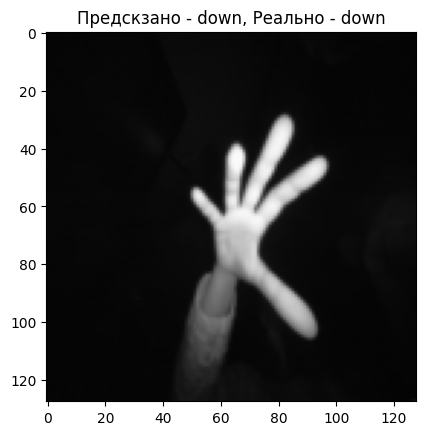

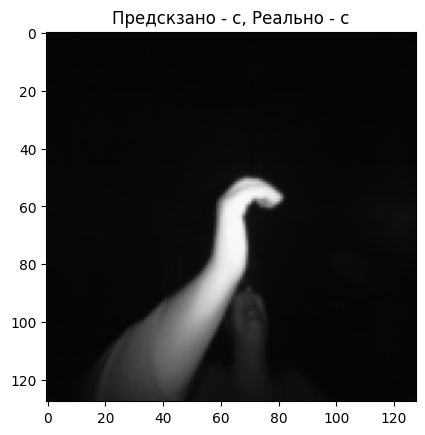

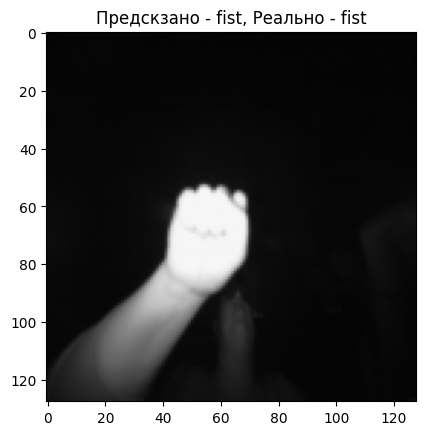

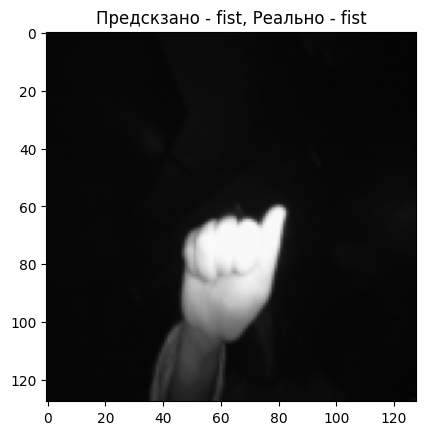

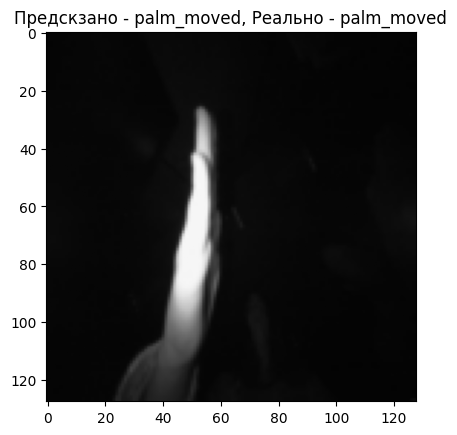

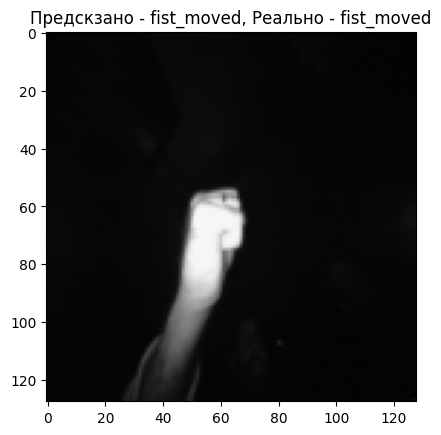

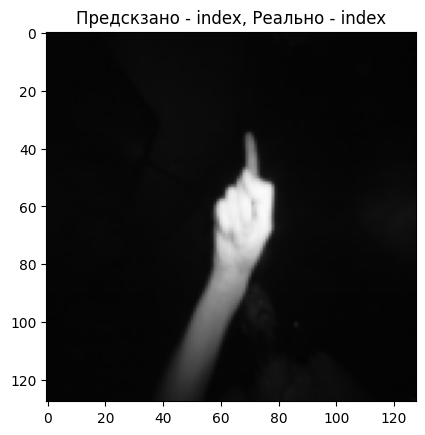

In [27]:
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = resnet(images)
        plt.title(f'Предскзано - {digit_to_classname(outputs[0].argmax())}, Реально - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>8:
            break

**Все работает отлично**  
Теперь можно сделать приложение классифицирующее жесты используя обученную сеть